In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect
import random
import shutil

from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy import optimize, ndimage
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import utils.dataset_utils as dataset
import utils.train_utils as train

In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

def split_Raman_af(X):
    """
    Removing spikes from the data to extract the autofluorescence.
    This is done by applying smoothing filter to the data and then taking the min of the smoothing filter and original data.
    """
    a = X
    # remove spikes from data
    a1 = ndimage.gaussian_filter(a, (0, 10), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 20), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 30), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 40), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 50), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 60), mode='nearest')
    a = np.min([a, a1], axis=0)
    
    # Restore Edges
    c = 50
    a[:,:c] = X[:,:c]
    a[:,-c:] = X[:,-c:]
    
    #smooth everyting
    for _ in range(100):
        a1 = ndimage.gaussian_filter(a, (0, 10), mode='nearest')
        a = np.min([a, a1], axis=0)
        a[:,0] = X[:,0]
        a[:,-1] = X[:,-1]
        
    return X-a, a

def smoothing(X, s=2):
    """
    Only remove noise from low noise to signal area's to maintain the intensity of the spikes.
    Noise is removed with a gaussian filter in spectral dimension.
    """
    grad = ndimage.gaussian_filter(X, (0, 1), order=1)
    grad_abs = np.abs(grad)
    grad_abs_sm = ndimage.gaussian_filter(grad_abs, (0, 1))
    mean_grad = np.mean(grad_abs)
    noise_to_signal_quality = ndimage.gaussian_filter((grad_abs_sm < mean_grad).astype(float), (0,s))
    return noise_to_signal_quality * ndimage.gaussian_filter(X, (0,s)) + (1-noise_to_signal_quality) * X


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [3]:
# use 368 to 1750
N_WAVE = 2126
s = 2
start_index, end_index = 0, 2129

X = np.load("../data/Raman/Alina_art_1_1.npy", 'r')
Y = np.load("../data/Raman/Alina_Art_4_2.npy", 'r')

wavelength = np.load("../data/Raman/wavelength.npy", 'r')

shape_X = X.shape 
shape_Y = Y.shape

X = copy.copy(X.reshape(-1, X.shape[-1]))
Y = copy.copy(Y.reshape(-1, Y.shape[-1]))

ram_X, afl_X = split_Raman_af(X)
ram_smooth_X = smoothing(ram_X, s)

ram_Y, afl_Y = split_Raman_af(Y)
ram_smooth_Y = smoothing(ram_Y, s)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, n_components=10, depth=2, neurons=100, bias=True, **kwargs):
        super().__init__()
        self.encode = nn.Sequential( 
            nn.Dropout3d(0.25),
            nn.Flatten(),
            nn.Linear(N_WAVE, neurons, bias=bias),
            nn.ReLU(True),
            *((nn.Linear(neurons, neurons, bias=bias),
            nn.ReLU(True)) * (depth-1)),
            nn.Linear(neurons, n_components, bias=bias),
            nn.Softmax(1),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(n_components, neurons, bias=bias),
            nn.ReLU(True),
            *((nn.Linear(neurons, neurons, bias=bias),
            nn.ReLU(True)) * (depth-1)),            
            nn.Linear(neurons, N_WAVE, bias=bias),
            View((-1,1,1,1,N_WAVE))
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))  

In [5]:
def MSE_loss(x, model):
    W = model.encode(x)
    x_ = model.decode(W)

    # maximize the difference in reference vectors
    reference_spectra_ = (W.T @ x.squeeze())
    reference_spectra_ = (reference_spectra_.T / (torch.sqrt((reference_spectra_**2).sum(axis=1)) + 10**-10)).T
    max_ref_diff = 0
    for i in range(W.size(1)):
        for j in range(i + 1, W.size(1)):
            max_ref_diff += 1 / (torch.abs(reference_spectra_[i] - reference_spectra_[j]).sum())
    max_ref_diff /= (W.size(1) * (W.size(1) - 1)) // 2 #number of combinations
    
    #MSE loss
    MSE = ((x_ - x)**2).sum(4).mean()  
    
    return MSE + max_ref_diff

In [16]:
class ReferenceVectorClassifierAE(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = {}
        self.ae_kwargs = {}        
        self.set_params(**kwargs)

        _use_cuda = torch.cuda.is_available() and kwargs['cuda']
        if _use_cuda:
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True
        self.device = torch.device('cuda' if _use_cuda else 'cpu')        
        
    def fit(self, x, **kwargs):
        self.set_params(**kwargs)
        X = unit_vector_norm(x)
        
        ###################### Autoencoder ################################
        self.model = AutoEncoder(**self.ae_kwargs).to(self.device)
        
        parameters = filter(lambda x: x.requires_grad, self.model.parameters())
        self.optimizer = optim.Adam(parameters)        
        train_loader, test_loader = dataset.load_liver(X, self.kwargs['batch_size'])
        
        for epoch in range(self.kwargs['epochs']):
            print('-'*50)
            print('Epoch {:3d}/{:3d}'.format(epoch+1, self.kwargs['epochs']))
            start_time = datetime.now()
            train.train(self.model, self.optimizer, train_loader, self.kwargs['loss_func'], self.kwargs['log_step'], self.device)
            end_time = datetime.now()
            time_diff = relativedelta(end_time, start_time)
            print('Elapsed time: {}h {}m {}s'.format(time_diff.hours, time_diff.minutes, time_diff.seconds))
            loss = train.test(self.model, test_loader, self.kwargs['loss_func'], self.device)
            print('Validation| bits: {:2.2f}'.format(loss), flush=True)    
          
        self.model.eval()
        with torch.no_grad():
            W = self.model.encode(dataset.load_liver_all(X).to(self.device))
        self.z = W
        W = W.cpu().detach().numpy()
        
        W1 = W - W.min(0)
        W1 /= W1.max(0)
        plt.figure(figsize = (20,4))
        plt.imshow(W1.reshape((*shape_Y[:2], self.kwargs['n_components']))[::-1,:,:3])
        plt.gca().invert_yaxis()
        plt.show()
#         plt.figure(figsize = (20,4))
#         plt.imshow(W1.reshape((*shape_Y[:2], self.kwargs['n_components']))[::-1,:,3:6])
#         plt.gca().invert_yaxis()
#         plt.show()                   
        ###################### reference spectra ################################
        self.reference_spectra_ = unit_vector_norm(W.T @ X)    
        self.ref_org = unit_vector_norm(W.T @ x)
                
        # Return the classifier
        return self
    
    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X = unit_vector_norm(X)
        
        ###################### RCA ################################           
        RCA_vector = np.array([optimize.nnls(self.reference_spectra_.T, X[i,:])[0] for i in range(X.shape[0])])

        return RCA_vector
    
    def get_reference_vectors(self):
        return self.reference_spectra_

    def get_org_reference_vectors(self):
        return self.ref_org    
    
    def get_params(self, deep=False):
        return self.kwargs
    
    def set_params(self, **kwargs):
        self.kwargs.update(kwargs)
        self.ae_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(AutoEncoder).parameters.keys())})     
        return self

In [17]:
def error_map(estimator, X, y=None):
    RCA = estimator.predict(X)
    ref_vec = estimator.get_reference_vectors()
    return ((RCA @ ref_vec - X)**2).mean(1)

def score_func(estimator, X, y=None):
    X = unit_vector_norm(X)
    return error_map(estimator, X).mean()

def print_mean_std(X):
    return f"{X.mean():<12.4e}{X.std():<12.4e}"

def cross_val_X_Y_Z(rvc, X, Y, Z):
    rvc.fit(np.concatenate((X, Y), axis=0))
    return score_func(rvc, Z)

In [21]:
kwargs = {'n_components': 3,
          'batch_size': 32,
          'cuda': True,
          'log_step': 30,
          'loss_func': MSE_loss,
          'epochs': 5,
          'depth': 2,
          'neurons': N_WAVE,
          'bias': True
         }

--------------------------------------------------
Epoch   1/  5
  2020-06-10 16:31:01|     0/  178| bits: 1831.96
  2020-06-10 16:31:02|    30/  178| bits: 1.88
  2020-06-10 16:31:02|    60/  178| bits: 2.05
  2020-06-10 16:31:03|    90/  178| bits: 1.67
  2020-06-10 16:31:04|   120/  178| bits: 2.24
  2020-06-10 16:31:05|   150/  178| bits: 2.76
Elapsed time: 0h 0m 7s
Validation| bits: 1.23
--------------------------------------------------
Epoch   2/  5
  2020-06-10 16:31:11|     0/  178| bits: 1.01
  2020-06-10 16:31:12|    30/  178| bits: 0.86
  2020-06-10 16:31:13|    60/  178| bits: 0.95
  2020-06-10 16:31:13|    90/  178| bits: 0.56
  2020-06-10 16:31:14|   120/  178| bits: 0.53
  2020-06-10 16:31:14|   150/  178| bits: 0.68
Elapsed time: 0h 0m 5s
Validation| bits: 0.70
--------------------------------------------------
Epoch   3/  5
  2020-06-10 16:31:19|     0/  178| bits: 0.74
  2020-06-10 16:31:20|    30/  178| bits: 0.80
  2020-06-10 16:31:21|    60/  178| bits: 0.64
  202

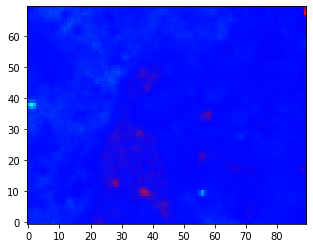

ReferenceVectorClassifierAE(batch_size=32, bias=True, cuda=True, depth=2,
                            epochs=5, log_step=30,
                            loss_func=<function MSE_loss at 0x0000022A7883D288>,
                            n_components=3, neurons=2126)

In [22]:
rvc = ReferenceVectorClassifierAE(**kwargs)
rvc.fit(afl_Y)

fit score:  1.4312774614150396e-06


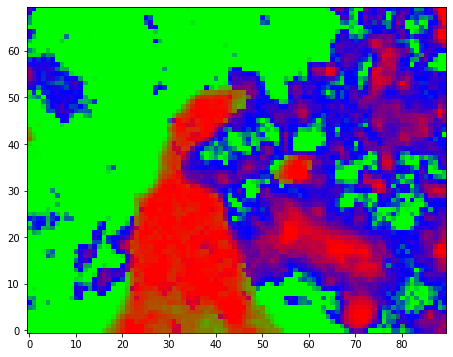

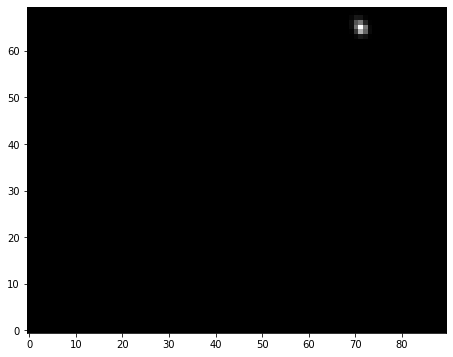

In [23]:
RCA_vector = rvc.predict(afl_Y)

print("fit score: ", score_func(rvc, afl_Y))

RCA_vector = np.abs(RCA_vector)
RCA_vector = RCA_vector - RCA_vector.min(0)
RCA_vector /= RCA_vector.max(0)

plt.figure(figsize = (20,6))
plt.imshow(RCA_vector.reshape((*shape_Y[:2], kwargs['n_components']))[::-1,:,:3])
plt.gca().invert_yaxis()
plt.show()
# plt.figure(figsize = (20,6))
# plt.imshow(RCA_vector.reshape((*shape_Y[:2], kwargs['n_components']))[::-1,:,3:6])
# plt.gca().invert_yaxis()
# plt.show()
plt.figure(figsize = (20,6))
plt.imshow(error_map(rvc, afl_Y).reshape(shape_Y[:2]), cmap='gray', vmin=0)
plt.gca().invert_yaxis()
plt.show()

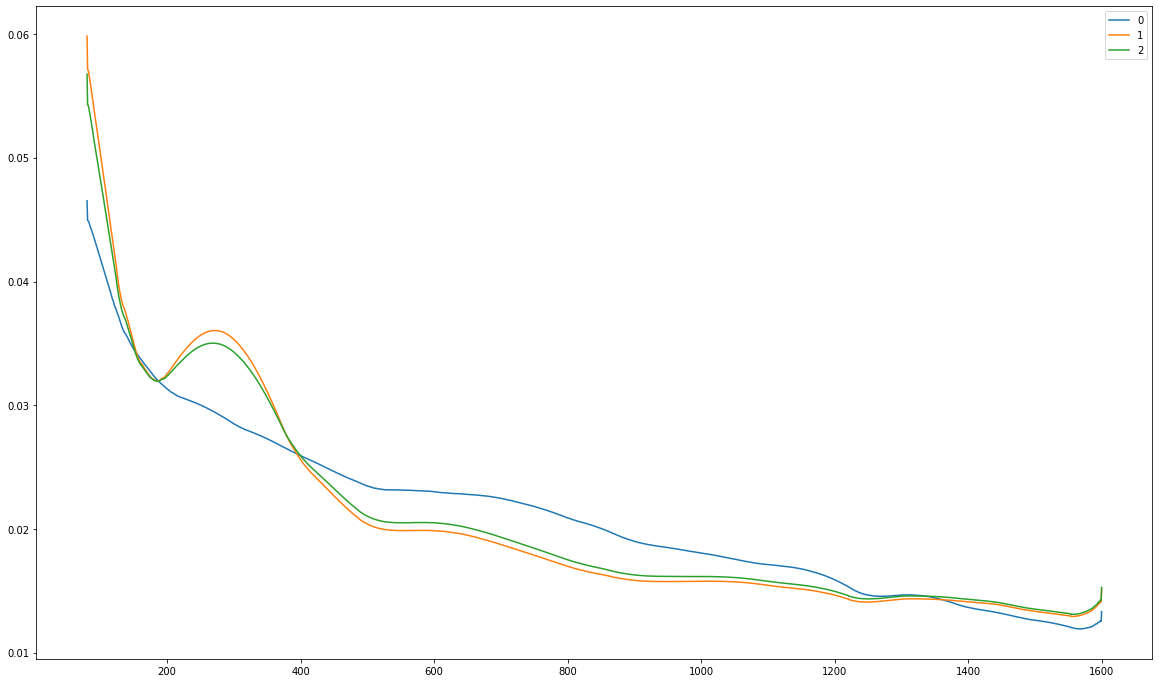

In [24]:
plt.figure(figsize = (20,12))
for i, r in enumerate(rvc.get_reference_vectors()):
    plt.plot(wavelength[:N_WAVE], r, label=i)
plt.legend()
plt.show()

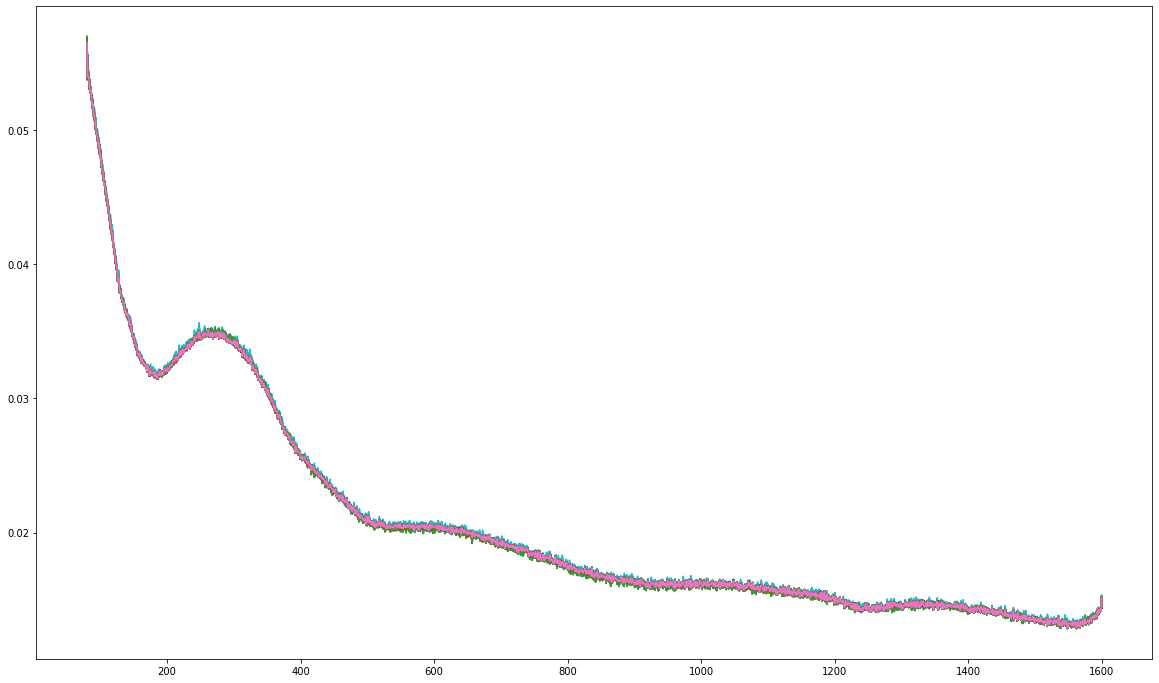

In [12]:
#reconstructing plot
with torch.no_grad():
    x_ = rvc.model(dataset.load_liver_all(unit_vector_norm(afl_Y)).to('cuda:0'))

plt.figure(figsize = (20,12))

for i in range(0,667,1):
    plt.plot(wavelength[:N_WAVE], x_[i].flatten().cpu().detach().numpy(),label='rec')
#     plt.plot(wavelength, unit_vector_norm(ram_smooth)[i] , label='org')    
# plt.legend()
plt.show()

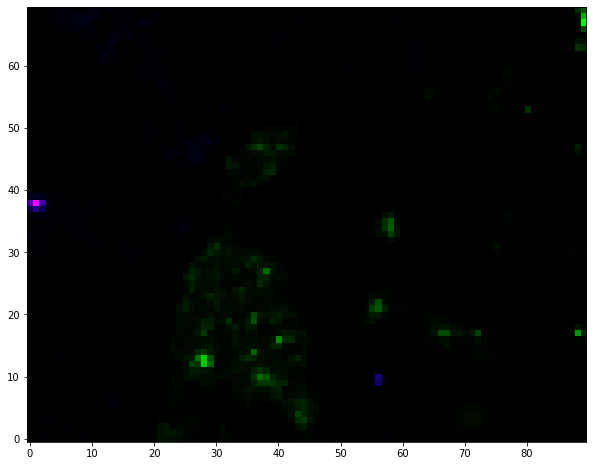

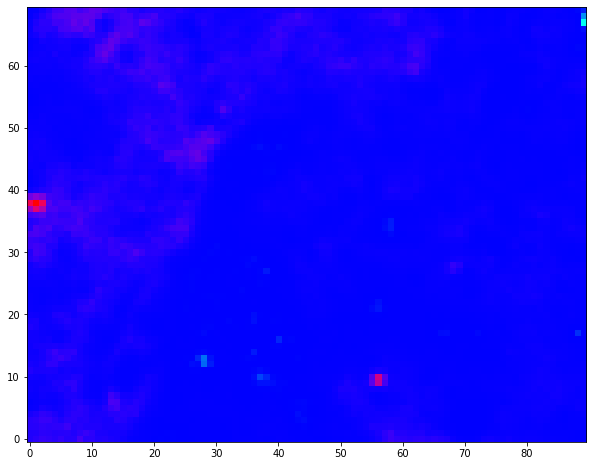

In [13]:
W = rvc.model.encode(dataset.load_liver_all(unit_vector_norm(afl_Y)).to('cuda:0'))
        
W = W.cpu().detach().numpy()
W1 = W - W.min(0)
W1 /= W1.max(0)

plt.figure(figsize = (20,8))
plt.imshow(W1.reshape((*shape_Y[:2], kwargs['n_components']))[::-1,:,:3])
plt.gca().invert_yaxis()
plt.show()
plt.figure(figsize = (20,8))
plt.imshow(W1.reshape((*shape_Y[:2], kwargs['n_components']))[::-1,:,3:6])
plt.gca().invert_yaxis()
plt.show()